In [1]:
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import uproot
import pandas as pd
import statistics as st
import os
from numba import njit
import time
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from loguru import logger
from datetime import datetime
from numba.typed import List

In [2]:
# warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
# warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
# warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# for arg in sys.argv:
#     run_num=str(arg).zfill(5)
#     # print(run_num)

# chan_enab = int(sys.argv[-1])
# run_start=str(sys.argv[1]).zfill(5)
# run_end=str(sys.argv[2]).zfill(5)
# run_num=str(sys.argv[3]).zfill(5)

run_num = '12034'
runs_folder = 'runs12034-12363/'
os.chdir('F:/LANL/')
datadir = 'sample_data/'
uniquefolder = 'debug_sample/'+runs_folder
SFNormFile = 'SF_Norm_files/'+runs_folder+run_num
statefileloc = 'F:\LANL\SF_Norm_files\TR_R_expected_avgs_stds_afterclip.csv'

# print(os.getcwd())

# os.chdir('F:/LANL/')
# datadir = 'D:/LANSCE_FP12_2023/data/' ## add directory of hard drive
# uniquefolder = "runs" + str(run_start) + "-" + str(run_end) +"/"
# SFNormFile = 'SF_Norm_files/'+uniquefolder+run_num

print('processing data: ' + uniquefolder + '/run' + run_num)

# statefileloc = 'F:\LANL\SF_Norm_files\TR_R_expected_avgs_stds_afterclip.csv'
# processedpulsefolder = '/processed_data/'+uniquefolder+'pulses_added_D/'
# processedasymfolder = '/processed_data/'+uniquefolder+'asym_D/'
# AddedPulseSavename = processedpulsefolder+run_num+'_pulsesadded_D'
# AsymSavename = processedasymfolder+run_num+'_asym_D'
# ONSavename = processedasymfolder+run_num+'_ON_D'
# OFFSavename = processedasymfolder+run_num+'_OFF_D'
# logger.add("F:/LANL/processed_data/" + uniquefolder + '0_ErrorLog_'+run_start+'_'+run_end+'_D.txt', delay = False)
# print('saving processed data to ' + AsymSavename)

## cannot handle all 24 detectors at once, memory issue... can look into np.empty and deleting variables if needed<br>
# chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]) ## all
chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,24]) ## downstream
# chan_enab = np.array([12,13,14,15,16,17,18,19,20,21,22,23,24]) ## upstream

# if not os.path.exists(os.getcwd()+processedpulsefolder) or not os.path.exists(os.getcwd()+processedasymfolder):
#     # Create the directory
#     os.makedirs(os.getcwd()+processedpulsefolder)
#     os.makedirs(os.getcwd()+processedasymfolder)
#     print("Directory created successfully")
# else:
#     pass

start = time.time()
fullstart = time.time()

# read_data = np.array([])
# fileLength = np.array([])
read_data = []
fileLength = []

def open_file():
    for el in chan_enab:
        # f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
        f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
        read_data.append(np.fromfile(file=f, dtype=np.uint16))
        f.close()
        fileLength.append(len(read_data[-1]))
    return read_data, fileLength

open_file()

fileLength = np.asarray(fileLength)
read_data = np.asarray(read_data) ## in detector's case, all are the same size samples, so can do read_data as np array

if chan_enab[-1] != 24:
    emessage = ('last channel is not 6Li detector')
    logger.error(run_num + emessage)
    raise Exception(emessage)

# print('saving processed data to ' + AsymSavename)
print("Channel is " + str(chan_enab))
end = time.time()
# print('file open time: ' + str(end-start))      
# print(read_data)

processing data: debug_sample/runs12034-12363//run12034
Channel is [ 0  1  2  3  4  5  6  7  8  9 10 11 24]


Store the big header for each channel in arrays

In [3]:
BoardID = []
recordLength = []
numSamples = []
eventCounter = []
decFactor = []
chanDec = []
postTrig = []
groupStart = []
groupEnd = []
timestamp= []
sizeFirstEvent = []
TTT = []

targetDict = {0: "La", 1: "Tb2O3", 2: "Yb2O3", 3: "Sm2O3", 4: "Er2O3", 5: "Ho2O3", 6: "other"}
foilDict = {0: "TBD", 1: "TBD", 2: "TBD", 3: "TBD", 4: "TBD", 5: "TBD", 6: "other"}

target=(read_data[0][5]&0x00F0)>>4
foil=read_data[0][5]&0x000F
targetFlag = read_data[0][5]>>8&1
foilFlag = read_data[0][5]>>9&1
spinFiltFlag = read_data[0][5]>>10&1
spinFlipFlag = read_data[0][5]>>11&1
shutterFlag = read_data[0][5]>>12&1
facilityTrigFlag = read_data[0][5]>>13&1

if targetFlag:
    target=targetDict[(read_data[0][5]&0x00F0)>>4]
else:
    target = "empty"
if foilFlag:
    foil=foilDict[read_data[0][5]&0x000F]
else:
    foil = "empty"
for i in range(0,len(chan_enab)):
    BoardID.append(read_data[i][9]>>8)
    recordLength.append(((read_data[i][9]&0x00FF)<<16)+read_data[i][8])
    numSamples.append(((read_data[i][11]&0x00FF)<<16)+read_data[i][10])
    eventCounter.append(read_data[i][6]+(read_data[i][7]<<16))
    BoardID.append(read_data[i][9]>>8)  
    decFactor.append(read_data[i][11]>>8)
    chanDec.append(read_data[i][13]>>8)
    postTrig.append(read_data[i][15]>>8)
    groupStart.append(((read_data[i][13]&0x00FF)<<16)+read_data[i][12])
    groupEnd.append(((read_data[i][15]&0x00FF)<<16)+read_data[i][14])
    timestamp.append(read_data[i][16]+(read_data[i][17]<<16)+(read_data[i][18]<<32)+(read_data[i][19]<<40))  
    sizeFirstEvent.append(read_data[i][0]+(read_data[i][1]<<16))
    TTT.append(read_data[i][2]+(read_data[i][3]<<16)+(read_data[i][4]<<32))
    
#     print("For channel " + str(chan_enab[i]) + ", BoardID is " + str(BoardID[i])
#           + "; record length is " + str(recordLength[i]) + "; num Samples is " 
#           + str(numSamples[i]) + "; event counter is " + str(eventCounter[i]) + "; dec factor is " + str(decFactor[i]) + "; chan dec is " 
#           + str(chanDec[i]) + "; postTrig is " + str(postTrig[i]) + "; group start is " + str(groupStart[i]) + "; group end is " + str(groupEnd[i])
#           + "; epoch time is " + str(timestamp[i]) +  "; first event size is " + str(sizeFirstEvent[i]) + "; and ETTT is " + str(TTT[i]) + "\n")

BoardID = np.asarray(BoardID) 
recordLength = np.asarray(recordLength)
numSamples = np.asarray(numSamples)
eventCounter = np.asarray(eventCounter)
decFactor = np.asarray(decFactor)
chanDec = np.asarray(chanDec)
postTrig = np.asarray(postTrig)
groupStart = np.asarray(groupStart)
groupEnd = np.asarray(groupEnd)
timestamp = np.asarray(timestamp)
sizeFirstEvent = np.asarray(sizeFirstEvent)
TTT = np.asarray(TTT)
print("Target is " + target)
# print("Foil is " + foil)
# print("Shutter is open: " + str(bool(shutterFlag)))
# print("Facility t0 is on: " + str(bool(facilityTrigFlag)))
# print("Spin flipper is on: " + str(bool(spinFlipFlag)))
# print("Spin filter is on: " + str(bool(spinFiltFlag)))
# print("Target is present: " + str(bool(targetFlag)))
# print("Foil is present: " + str(bool(foilFlag)))

Target is La


Determine the time axis for each channel

In [4]:
preTime = []
startTime = []
endTime = []
resolution = []
xs = [] 

for i in range(0,len(chan_enab)):
    preTime.append((100-postTrig[i])*recordLength[i]/100)
    startTime.append((-1*preTime[i]*16*decFactor[i] + groupStart[i]*16*decFactor[i]))
    endTime.append((-1*preTime[i]*16*decFactor[i] + groupEnd[i]*16*decFactor[i]))
    resolution.append(16*chanDec[i]*decFactor[i])
#     print("Pretime for channel", chan_enab[i],"is " + str(preTime[i]) + "; start time is " + str(startTime[i]) + "; end time is " + str(endTime[i]) 
#           + "; resolution is " + str(resolution[i]) + "ns")
    xs.append(np.arange(startTime[i],(numSamples[i])*resolution[i]+startTime[i], resolution[i]))

# np.asarray(preTime) 
# np.asarray(startTime) 
# np.asarray(endTime) 
# np.asarray(resolution)
xs = np.asarray(xs) ## can convert xs to np array here because all detectors same numsamples

In [5]:
start=time.time()

@njit
def dataread(data, channels, fileLen, numSamps):
    numRuns = int((fileLen[0]-20-numSamps[0])/(numSamps[0]+6)+1)
    ys_arr = np.zeros((len(channels), numRuns,numSamps[0]), dtype=np.uint16)
    ETTT_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    eventcount_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    for i in range(0,len(channels)):
        eventCount = 0
        byteCounter = 0
            #byte counter is really 2bytecounter, lol
        while byteCounter < fileLen[i]:
            if byteCounter == 0:
                ETTT_arr[i]=TTT[i]
                #ETTT_arr[i].append(TTT[i])
                eventcount_arr[i]=(eventCounter[i])
                byteCounter = 20
            else:
                ETTT_arr[i]=(data[i][byteCounter]+(data[i][byteCounter+1]<<16)+(data[i][byteCounter+2]<<32))
                eventcount_arr[i]=(data[i][byteCounter+4]+(data[i][byteCounter+5]<<16))
                byteCounter += 6
            for j in range(0, numSamps[i]):
                #if j == 0:
                    #ys_arr[i].append([])
                #print(byteCounter)
                ys_arr[i][eventCount][j]=data[i][byteCounter]
                byteCounter += 1
            eventCount += 1
    return ys_arr, ETTT_arr, eventcount_arr

# start=time.time() 
# ys_arrHe, ETTT_arrHe, eventcount_arrHe  = dataread(read_data, [25], fileLength, numSamples) ##hardcoded channel 25 for He
ys_arr, ETTT_arr, eventcount_arr  = dataread(read_data, chan_enab, fileLength, numSamples) ##hardcoded channels for coils

end = time.time()
print('dataread from binary time: ' + str(end-start))

dataread from binary time: 2.602123260498047


In [6]:
timeDif=[]
for i in range(0,len(chan_enab)):
    timeDif.append([])
    for j in range(len(ETTT_arr[i])-1):
        timeDif[i].append((ETTT_arr[i][j+1]-ETTT_arr[i][j])*8)
#     print("Min time difference for channel", chan_enab[i], "is", min(timeDif[i]), "ns")
#     print("Max time difference for channel", chan_enab[i], "is", max(timeDif[i]), "ns \n")
#print(timeDif)

Load in SF and He normalization information ##

In [7]:
# try:
#     df_SF = pd.read_hdf(SFNormFile + '.h5', key='df_0')
#     df_HE = pd.read_hdf(SFNormFile + '.h5', key='df_1')
# except Exception as e:
#     logger.error(run_num + ' failed during SFNormFile load')
#     logger.exception(e)

# SF_Sort_arr = df_SF[['nicknames', 'transition_locations']].to_numpy().T
# He_Norm_arr = df_HE[['pulse', 'norms']].to_numpy().T

# NormFactor = 1000000  ## He integrals are huge, this normalizes all of those by a constant value for ease of use
# HeNorms= (He_Norm_arr[1])/NormFactor

# # print(SF_Sort_arr) 
# # print(He_Norm_arr[1]/NormFactor)

In [8]:
# basesub and plotting ##

baseL = 0
baseR = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])  ##70% before the trigger
numRuns = int((fileLength[0]-20-numSamples[0])/(numSamples[0]+6)+1)
legend =  ['NaI', 'R']

start = time.time()

s = 20 ## pulse to look at 
t=s+1

#  dont know why this is so slow ##
def plotter(ys, xs, baseR, numpoints):
    tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=float)
    for i in range((len(ys))):
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseL:baseR]))
        for j in range(s, t): ## plot only interested pulses
            plt.plot(xs[i], tempys_basesub[i][j]) #label=legend[i]) #+str(sums[1][j])) ## sums[j] will not work for more than just TR   
            plt.axvline(xs[0][baseL], ls = '--')
            plt.axvline(xs[0][baseR], ls = '--')
            #plt.axvline(xs[0][int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])], ls = '--', c ='m')
            plt.axvline(xs[0][baseR+5], ls = '--', c ='r') ## BaseR+5 line marks the beginning of the integral, until the end of samples.
#             plt.title('SF state transition' + transitions[p]) 
#             plt.xlabel("time from trigger (ns)")
#             plt.ylabel("ADC")
#             plt.legend()
            
# plotter(ys_arr[9:], xs[9:], baseR, numSamples) ##plot coils

ys_basesub = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)
# ys_basesub_norm = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)

## BASESUB ALSO CHANGES TO microQ NOW! 09.03.24
@njit ## jit is faster for large # channels, slower for small # channels
def basesub(ys, baseRight, numpoints):
#     uQ_sec = ((2/4096)/50)*1000000 ## 4096 ADC = 2V, divide by 50Ohm to get I [Q/sec], change to microQ
#     ys = ys*uQ_sec
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
    return tempys_basesub

## BASESUB ALSO CHANGES TO microQ NOW! 09.03.24
@njit ## jit is faster for large # channels, slower for small # channels
def basesub_norm(ys, baseRight, numpoints): 
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
#     uQ_sec = ((2/4096)/50)*1000000 ## 4096 ADC = 2V, divide by 50Ohm to get I [Q/sec], change to microQ
#     ys = ys*uQ_sec
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
        tempys_basesub[pulse]=tempys_basesub[pulse]/HeNorms[pulse] 
    return tempys_basesub

# for peak finding algo., we don't want to use the normalization yet...
for i in range(len(ys_basesub)): ## feeding y arrays into function 1 channel at  a time is faster than all at once
    ys_basesub[i] = basesub(ys_arr[i], baseR, numSamples)
# for i in range(len(ys_basesub)): ## if not using aligning/cutting later, ys should be normalized here
#     ys_basesub[i] = basesub_norm(ys_arr[i], baseR, numSamples)

ys_basesub[-1] = ys_basesub[-1]*-1 ## invert 6Li to positive signal. Comment out if not using
# ys_basesub_norm[-1] = ys_basesub_norm[-1]*-1 ## invert 6Li to positive signal. Comment out if not using

end = time.time()
print('plotting and/or base subtraction time: ' + str(end-start))            

plotting and/or base subtraction time: 8.76322889328003


In [9]:
# use 6Li t0 for all instead of for themselves individually ##
NaIthresh=2000
Li6thresh=1000

threshold_array = (np.full(len(ys_basesub), NaIthresh))
threshold_array[-1] = Li6thresh

# njit ## numba does not support reversed, but this could be changed if it's slow

def find_offset(ys, thresharr):
    xCrosses = np.zeros((len(ys), numRuns)) #outer array is crossing arrays for given channel, inner array is crossing for each event
    offset = np.zeros((len(ys), numRuns), dtype=np.int32) ##offset in bins for each channel, each pulse
    modeCrosses = np.zeros((len(ys)), dtype=np.float64)
    for i in reversed(range(len(ys))):
        #xValues.append([])
        for p in range(len(ys[i])):
            xing = np.argmax(ys[i][p] > thresharr[i])
            #print(xing)
            xCrosses[i][p] = xing
        modeCrosses[i] = (st.mode(xCrosses[i])) #find the most typical crossing value for each channel
        for p in range(len(xCrosses[i])):
            offset[i][p] = (modeCrosses[-1] - xCrosses[i][p]) ## make sure this is the correct sign!!! 
    if (np.all(xCrosses[-1])) == False:
        emessage = ('ERROR: 6Li threshold was not reached for at least one pulse')
        logger.error(run_num + emessage)
        raise Exception(emessage)
    return offset, xCrosses, modeCrosses
                           
offset, xCrosses, modeCrosses = find_offset(ys_basesub, threshold_array)

end = time.time()
# print('finding offset time: ' + str(end-start))  

# extend all arrays by a value, check that the max number of offset on 6Li is less than that value ##
start = time.time()

extendedRange = 3 ## must be a positive value which to extend ys_arr
if abs(max(offset[-1], key = abs)) > extendedRange: ## if the max offset of 6Li is >extendedRange, something is wrong
    emessage = ('ERROR: largest offset greater than extended range')
    logger.error(run_num + emessage)
    raise Exception(emessage)

try:
    ys_ext = np.zeros((len(ys_basesub), len(ys_basesub[0]), len(ys_basesub[0][0])+extendedRange*2), dtype=np.float64)
    ys_cut = np.zeros((len(ys_basesub), len(ys_basesub[0]), (len(ys_ext[0][0])-((extendedRange*2)+1)*2)))
    xs_cut = np.zeros((len(ys_cut), len(ys_cut[0][0])))
except Exception as e:
    logger.error(run_num + ' failed during ys_cut array creation')
    logger.exception(e)

# cant use jit because np.pad is not supported ##

def align_cut(ys, xs_arr, extendedr):
    tempys_ext = np.zeros((len(ys), len(ys[0])+extendedr*2), dtype=np.float64)
    tempys_cut = np.zeros((len(ys), (len(tempys_ext[0])-((extendedr*2)+1)*2)))
    tempxs_cut = np.zeros(len(tempys_cut[0]))
    for p in range(len(ys)):
        tempys_ext[p] = np.pad(ys[p], extendedr, 'constant', constant_values=(0))
        tempys_ext[p] = np.roll(tempys_ext[p],offset[-1][p]) ## assumes 6Li at -1 position
        tempys_cut[p] = tempys_ext[p][((extendedr*2)+1):-((extendedr*2)+1)].copy() ## cut by 7 (if extRange == 3)
#         tempys_cut[p] = tempys_cut[p]/HeNorms[p] ## normalize by 3He integral  ## comment out if using basesub_norm
    x_cut_amt = int((len(ys[0]) - len(tempys_cut[0]))/2)
    tempxs_cut = xs_arr[x_cut_amt:-x_cut_amt].copy()
    return tempys_cut, tempxs_cut

try:
    for i in range(len(ys_basesub)):
        ys_cut[i], xs_cut[i] = align_cut(ys_basesub[i], xs[i], extendedRange)
except Exception as e:
    logger.error(run_num + ' failed aligning and cutting')
    logger.exception(e)
    
# checkp = 2053
# print(offset[-1][checkp]) ## checking offset for one example checkpulse
# print('original index for checkpulse: '+str(np.argmax(ys_basesub[0][checkp]> 2000))) ## we can follow the index as it changes with extension/cut
# #print('extended range index for checkpulse: '+str(np.argmax(ys_ext[0][checkp]> 2000)))
# print('cut array index for checkpulse: '+str(np.argmax((ys_cut[0][checkp]*HeNorms[checkp])> 2000)))

del ys_ext ## might help with memory issues
del ys_basesub

end = time.time()
print('aligning and cutting time: ' + str(end-start))            

aligning and cutting time: 25.85158109664917


In [10]:
# %matplotlib qt
# s = 342 ## pulse to look at 
# t=s+1
# ch = 0
    
# leg =  ['NaI', 'R']
# plt.legend(leg)
# plt.title('One pulse') 
# plt.xlabel("time from trigger (ns)")
# plt.ylabel("ADC")
# # plt.ylabel("uC/sec")

# # ys_subset = ys_basesub[11][0][5000:9000].copy()
# # xs_subset = xs[0][5000:9000].copy()
# ys_subset = ys_basesub[ch][s].copy()
# xs_subset = xs[ch].copy()

# peaks, _ = sp.signal.find_peaks(ys_subset, height=0)
# plt.plot(xs_subset, ys_subset)
# # plt.plot(ys_subset[peaks],peaks, "x")
# plt.axvline(xs[0][7600], ls = '--', c ='g')
# plt.axvline(xs[0][8000], ls = '--', c ='g')
# plt.axvline(xs[0][1500], ls = '--', c ='g')
# plt.show()

# plt.axvline(xs[0][baseL], ls = '--')
# plt.axvline(xs[0][baseR], ls = '--')

# plt.axvline(xs[1][intgrR], ls = '--', c ='g')
# plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
# plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

# plotter(ys_basesub[10:], xs[10:], baseR, numSamples) ##plot coils


### find peaks, integrate

In [11]:
# peak lengths are defined per pulse after being found; can maybe using numpy after that??
# split into 2 functions to use JIT?

## I think this has been confirmed to work using the singular finding method done earlier (below in troubleshooting).
# @njit
def find_peaks_2(ys, pkparam, peakrange): ## ys here is for one channel!
#     pulse_arr = [[],[]] ## peaks index, pulse sum ranges
    all_peaks = []
    sum_ranges = []
    ext = 40  ## how much to extend range by. Otherwise, can miss some peaks at the ends due to prominence
    for p in range(len(ys)):  ## find peaks for every pulse p in one detector channel
#         print(p)
        p_sum_ranges = []
        if peakrange[0] <= 0:
            peaks, _ = sp.signal.find_peaks(ys[p][peakrange[0]:peakrange[1]+ext], threshold=pkparam[0], prominence=pkparam[1], height=pkparam[2])#, height  = [1,1000])
        else:
            peaks, _ = sp.signal.find_peaks(ys[p][peakrange[0]-ext:peakrange[1]], threshold=pkparam[0], prominence=pkparam[1], height=pkparam[2])#, height  = [1,1000])
            peaks = peaks+peakrange[0]-ext
#         print(peaks)
        temp_i = np.array(np.where((peaks>=peakrange[0]+2) & (peaks<=peakrange[1]-2))[0], copy=True)
        peaks = peaks[temp_i]
        all_peaks.append(peaks)
    return all_peaks 


In [12]:
# now try 2nd version

start = time.time()
peakthresh = 2 ## threshold for peaks is estimated
prom = 10
h = [0,750] 
param = [peakthresh, prom, h] ## all peak finding parameters

grange = 1400
peak_range_beg = [0, grange] ## hardcoded for 0-1400 and 7600-9000
peak_range_end = [(len(ys_cut[0][0])-grange), len(ys_cut[0][0])]

pks_beg = []
pks_end = []

for i in range(len(ys_cut[:-1])):
    print('channel ' + str(chan_enab[i]))
    pks_beg.append(find_peaks_2(ys_cut[i], param, peak_range_beg))
    pks_end.append(find_peaks_2(ys_cut[i], param, peak_range_end))

end = time.time()
print('finding peaks time: ' + str(end-start))

channel 0
channel 1
channel 2
channel 3
channel 4
channel 5
channel 6
channel 7
channel 8
channel 9
channel 10
channel 11
finding peaks time: 21.088075399398804


In [13]:
@njit
def integrate_peaks_jit_2(ys, peaks): ## ranges in which to integrate int_ranges = [[2,6], [6,10]], 2 len array for each point
    peak_integrals = List()
    for p in range(len(peaks)):  ## find integral of peaks for every pulse p in one detector channel
#         print(p)
        peak_ints = np.zeros((len(peaks[p])), dtype = np.float64)
#         peak_ints = [0]*(len(int_ranges[p]))
#         print(p)
#         print(len(peak_ints))
        for pk in range(len(peaks[p])):  ## size of the peaks for every pulse
            start_point = peaks[p][pk]-2 ## try this to condense code. Basically, the beginning of where to integrate
            end_point = peaks[p][pk]+2
#             print(end_point)
            for point in range(start_point,end_point+1): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                peak_ints[pk] = np.add(peak_ints[pk],ys[p][point]) ## start with zeros, add to each iteratively
        peak_integrals.append(peak_ints)
    return peak_integrals
    
start = time.time()

ints_beg_jit_2 =List()
ints_end_jit_2 =List()

for i in range(len(pks_beg)):
    print('channel ' + str(chan_enab[i]))
    ints_beg_jit_2.append(integrate_peaks_jit_2(ys_cut[i], pks_beg[i]))
    ints_end_jit_2.append(integrate_peaks_jit_2(ys_cut[i], pks_end[i]))

end = time.time()
print('integrating peaks time: ' + str(end-start))


channel 0


C:\Users\gabeo\anaconda3\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'peaks' of function 'integrate_peaks_jit_2'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\gabeo\AppData\Local\Temp\ipykernel_6260\3421468145.py", line 2:
@njit
def integrate_peaks_jit_2(ys, peaks): ## ranges in which to integrate int_ranges = [[2,6], [6,10]], 2 len array for each point
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


channel 1
channel 2
channel 3
channel 4
channel 5
channel 6
channel 7
channel 8
channel 9
channel 10
channel 11
integrating peaks time: 16.335442543029785


making histograms, changing to [uC]: 6.0130774974823


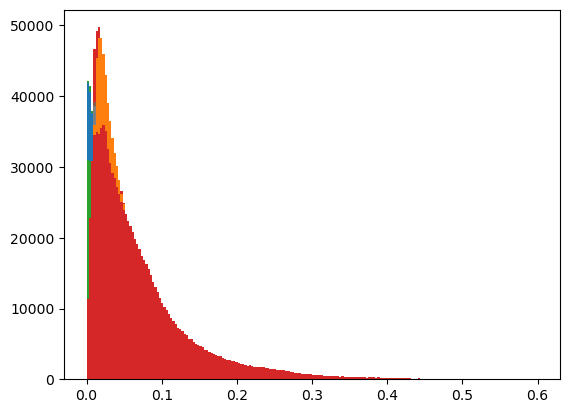

In [14]:
plt.ioff()
start = time.time()
Q_sec = ((2/4096)/50) ## 4096 ADC = 2V, divide by 50Ohm to get I [Q/sec]
sec = (512*(10e-9))

ints_beg_all = [] ## all pulse mode integrals for a given channel
ints_end_all = []
jit_np_beg = np.asarray(ints_beg_jit_2, dtype = object)
jit_np_end = np.asarray(ints_end_jit_2, dtype = object)

for i in range(len(ints_beg_jit_2)):
    ints_beg_all.append(np.hstack(jit_np_beg[i]*Q_sec*sec))
    ints_beg_all[i] = ints_beg_all[i]*10e6  ## convert to uC
    ints_end_all.append(np.hstack(jit_np_end[i]*Q_sec*sec))
    ints_end_all[i] = ints_end_all[i]*10e6
    
histdat_beg = [] ## all pulse mode histograms from the integrals
histdat_end = []
    
for i in range(len(ints_beg_all)):
    beghist = ints_beg_all[i]
    endhist = ints_end_all[i]
    beg_binval = plt.hist(beghist, bins = 200, range = [0, 0.60]) ## this is a 2d array of bin y values and their bin locations
    end_binval = plt.hist(endhist, bins = 200, range = [0, 0.60])
    histdat_beg.append(beg_binval)  ## 2d array of [[counts values], [bin locations (1 extra)]]
    histdat_end.append(end_binval)

end = time.time()
print('making histograms, changing to [uC]: ' + str(end-start))

In [15]:
## maybe include peak locations? but this would be a ch*pulse*# peaks sized array, very long

cols = ['channel', 'begregion_integrals[uC]', 'endregion_integrals[uC]', 'begregion_hist[uC]', 'endregion_hist[uC]']
intsData = [chan_enab[:-1], ints_beg_all, ints_end_all, histdat_beg, histdat_end]
print(len(intsData))


df_ints = pd.DataFrame({cols[0]: intsData[0],            
                    cols[1]: intsData[1],
                    cols[2]: intsData[2],
                    cols[3]: intsData[3],
                    cols[4]: intsData[4]})

# print(df_ints)

5


In [16]:
# df_ints.to_hdf('F:/LANL/testhistogramsDF' + '.h5', f'df_0', mode='w') ## this "deletes" any previous data in the file name

In [ ]:
fullend = time.time()
print('gamma region analysis done, full time: ' + str(fullend-fullstart))
print('finished ' + str(datetime.now())) 
print('\n')

## end of data processing ##

In [19]:
### testing end historgam - beg histogram
%matplotlib qt

testarr1 = df_ints['begregion_hist[uC]'].to_numpy()
testarr2 = df_ints['endregion_hist[uC]'].to_numpy()
# print(testarr1[0])
# print(len(testarr1[0]))

ch = 0
print(len(testarr2[ch]))

# print(testarr2[0][0])
testxbeg = testarr1[ch]
testxend = testarr2[ch]
testx = (testxend)

testend_beg = testxend[0]-testxbeg[0]
plt.bar(testx[1][:-1], testend_beg, width = max(testx[1])/len(testx[0]))  ## this plots the previous histogram !!!
plt.xlabel('uC')
plt.title('end-beg region pulse integrals run ' + run_num)
plt.show() 

3
